In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import gc
import xarray as xr
import numpy as np


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import pylab as pl
import mpl_toolkits.axisartist
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import LogNorm
import string

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset, _extract_interface

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

##File of fancy plot style. To use des.mplstyle file you must have an LaTeX distribution in your system
plt.style.use(machine_path+'/opt/mandyoc-scripts/sty/mandyoc.mplstyle')

In [8]:
def calc_mean_temperaure_region(data, Nz, xx, begin, end):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nz: int
        Number of points in Z direction

    xx: numpy.ndarray
        2D grid with x cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    arr: `numpy.ndarray`
        Array containing the horizontal mean of selected region
    '''

    x_region = (xx >= begin) & (xx <= end)
    Nx_aux = len(x_region[0][x_region[0]==True])
    data_sel = data[x_region].reshape(Nz, Nx_aux)
    data_sel_mean = np.mean(data_sel, axis=1)
    
    return data_sel_mean
def Tp_estimate(mean_temp, z, zbot, ztop):
    zcond = (z<=zbot+40) & (z>=ztop+40) #considering air layer

    zcut = z[zcond]
    tcut = mean_temp[zcond]

    params = curve_fit(fit_func, zcut, tcut)
    [a, b] = params[0]

    tfit = a*z + b #temeprature fitted

    #find the mantle potential temperature
    idx = np.where(z == 40.0)[0][0] #air thickness = 40 
    Tp = int(np.round(tfit[idx], 0))

    return Tp, tfit

def fit_func(x, a, b):
    return a*x + b


In [9]:
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Path to the model directory
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT200_HprodAst_Lx3000km'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT290_HprodAst_Lx3000km'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/keel_stable_DT350_HprodAst_Lx3000km'
# scenario = '/Doutorado/cenarios/mandyoc/keel/stable_DT200_keel_HprodAst'

scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT200_HprodAst_Lx4000km_ck'

# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    external_media = 'Joao_Macedo'
    if(path[1] == 'home'):
        model_path = f'/media/joao_macedo/{external_media}{scenario}'
    elif(path[1] == 'Users'):
        model_path = f'/Volumes/{external_media}{scenario}'

print(f'Model Path: {model_path}\n')

model_name = scenario.split('/')[-1]
print(f'Model name: {model_name}')

# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
print(f'Output Path: {output_path}')

if not os.path.isdir(output_path):
    os.makedirs(output_path)

Model Path: /media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT200_HprodAst_Lx4000km_ck

Model name: keel_stable_DT200_HprodAst_Lx4000km_ck
Output Path: /media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT200_HprodAst_Lx4000km_ck/_output


In [19]:
dataset = xr.open_dataset(f'{model_path}/_output_temperature.nc')

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

instant = dataset.time[-1]

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(dataset.info)

<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (time: 401, x: 401, z: 71)
Coordinates:
  * time         (time) float64 0.0 2.5 5.0 7.5 10.0 ... 992.5 995.0 997.5 1e+03
    step         (time) int32 ...
  * x            (x) float64 0.0 1e+04 2e+04 3e+04 ... 3.98e+06 3.99e+06 4e+06
  * z            (z) float64 -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    temperature  (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                401
    nz:                                71
    lx:                                4000000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rate_units:                 s^(-1)
    pressure_u

Text(0, 0.5, 'Depth [km]')

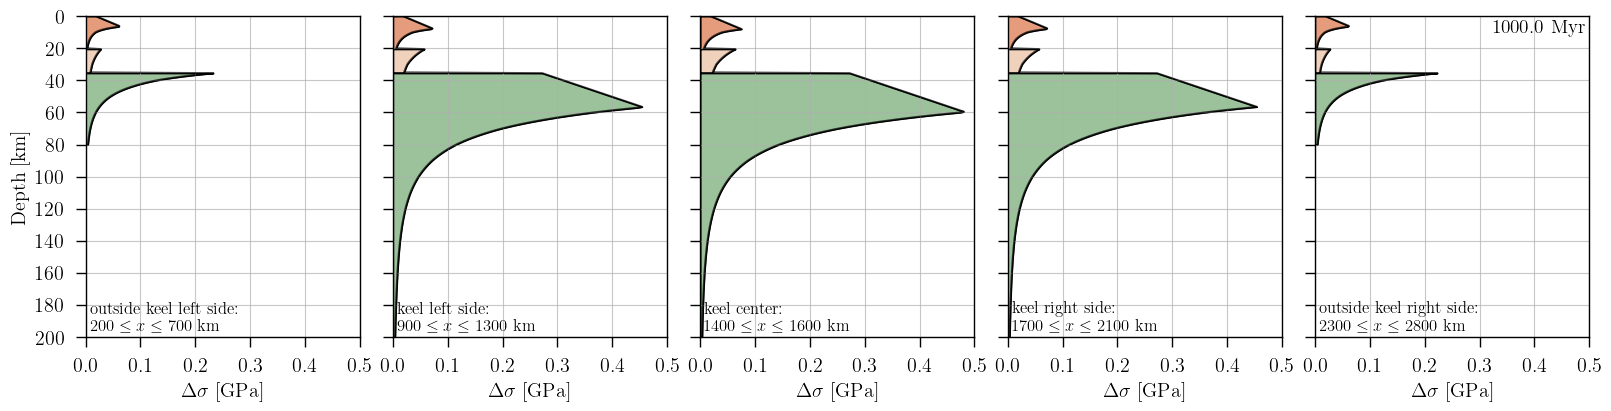

In [54]:
def calc_and_plot_YSE(ax, T_mean_region, z,
                      clc = 10,
                      thickness_sa = 40 * 1.0e3,
                      thickness_upper_crust = 20 * 1.0e3,
                      thickness_lower_crust = 15 * 1.0e3,
                      thickness_litho = 80 * 1.0e3):
###################################################################################

    # Creating YSE

    L = thickness_litho #select from z axis of the scenario
    N = int(2*thickness_litho/1.0e3 + 1)
    z_yse = np.linspace(0, L, N)
    dz_yse = z_yse[1]-z_yse[0]

    f = interp1d(z, T_mean_region)
    T_interp = f(z_yse/1.0e3)

    rho = np.zeros_like(z_yse)

    #conditions for regions
    uc = (z_yse <= thickness_upper_crust)
    lc = (z_yse > thickness_upper_crust) & (z_yse <= thickness_upper_crust + thickness_lower_crust)
    lm = (z_yse > thickness_upper_crust + thickness_lower_crust)

    rho[uc]=2700.0
    rho[lc]=2800.0
    rho[lm]=3354.0
    g = 10.0

    P = 0.0
    Paux = 0.0
    for i in range(1, N):
        Paux += dz_yse*rho[i]*g
        P = np.append(P, Paux)

    phi = 2.0*np.pi/180.0
    c0 = 4.0E6
    sigma_min = c0 * np.cos(phi) + P * np.sin(phi)

    phi = 15.0*np.pi/180.0
    c0 = 20.0E6
    sigma_max = c0 * np.cos(phi) + P * np.sin(phi)

    #rheological params
    Q = np.zeros_like(z_yse)
    A = np.zeros_like(z_yse)
    n = np.zeros_like(z_yse)
    V = np.zeros_like(z_yse)
    C = np.zeros_like(z_yse)

    Q[uc]=222000.0
    Q[lc]=222000.0
    Q[lm]=540000.0

    A[uc]=8.574E-28
    A[lc]=8.574E-28
    A[lm]=2.4168E-15

    n[uc]=4.0
    n[lc]=4.0
    n[lm]=3.5

    V[uc]=0.0
    V[lc]=0.0
    V[lm]=25.0E-6

    #strain rate (sr)
    sr = 1.0E-15

    #gas constant
    R = 8.314

    #print(n)

    #Temperature Kelvin
    TK = T_interp + 273

    #Viscosity
    #Choosing C for layers
    C[uc]=1.0
    C[lc] = clc
    C[lm]=1.0
    
    visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))

    sigma_v = visc * sr

    cond = sigma_v>sigma_max
    sigma_v[cond]=sigma_max[cond]

    ax.plot(sigma_v/1.0E9, z_yse/1000, linestyle=line, color=color, alpha=0.7)

    if clc==Cslc[-1]:
        cr = 255.
        color_uc = (228./cr, 156./cr, 124./cr)
        color_lc = (240./cr, 209./cr, 188./cr)
        color_lit = (155./cr, 194./cr, 155./cr)
        color_ast = (207./cr, 226./cr, 205./cr)

        #filling inside YSE
        ax.fill_betweenx(z_yse[uc]/1000, z_yse[uc]*0, sigma_v[uc]/1.0E9, color=color_uc, ec="k")
        ax.fill_betweenx(z_yse[lc]/1000, z_yse[lc]*0, sigma_v[lc]/1.0E9, color=color_lc, ec="k")
        ax.fill_betweenx(z_yse[lm]/1000, z_yse[lm]*0, sigma_v[lm]/1.0E9, color=color_lit, ec="k")

        # gray=0.
        # ax.plot(sigma_min/1.0E9, z_yse/1000, "--", color=(gray,gray,gray))
        # ax.plot(sigma_max/1.0E9, z_yse/1000, "--", color=(gray,gray,gray))

    ax.set_xlim([0, 0.5])
    ax.set_xticks(np.linspace(0, 0.5, 6))
    # ax.set_ylim([thickness_litho/1.0e3, 0])
    ax.set_ylim([200, 0])
    ax.set_yticks(np.linspace(0, 200, 11))

#Extracting temperature dataset
i = -1
data = dataset.temperature[i].values.T #Nz vs Nx
time = dataset.time[i].values

############################################################################################

#Calculating mean temperature profile for different regions
xcenter = (Lx/2)/1.0e3
keel_mean_l = calc_mean_temperaure_region(data, Nz, xx, xcenter - 600, xcenter - 200)
keel_mean_c = calc_mean_temperaure_region(data, Nz, xx, xcenter - 100, xcenter + 100)
keel_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 200, xcenter + 600)

out_mean_l = calc_mean_temperaure_region(data, Nz, xx, 200, xcenter - 800)
out_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 800, Lx/1.03 - 200)

z_aux = z - thickness_sa/1.0e3
cond1 = z_aux >= 0

temperature_profiles = [out_mean_l, keel_mean_l, keel_mean_c, keel_mean_r, out_mean_r]
Hlits = [80.0e3, 200.0e3, 200.0e3, 200.0e3, 80.0e3]

plt.close()
fig, axs = plt.subplots(1, 5, figsize=(16,4), sharex=True, sharey=True, constrained_layout=True)
axs.flatten()

for ax, temp_profile, thickness_litho in zip(axs, temperature_profiles, Hlits):
    calc_and_plot_YSE(ax, temp_profile[cond1], z_aux[cond1], thickness_litho=thickness_litho)


#Set plot details
locations = [f'outside keel left side:\n $200 \leq x \leq 700$ km',
             f'keel left side:\n $900 \leq x \leq 1300$ km',
             f'keel center:\n $1400 \leq x \leq 1600$ km',
             f'keel right side:\n $1700 \leq x \leq 2100$ km',
             f'outside keel right side:\n $2300 \leq x \leq 2800$ km'
            ]

for ax, location in zip(axs, locations):
    ax.grid('-k', alpha=0.7)
    ax.set_xlabel(r'$\Delta\sigma$ [GPa]')
    ax.text(0.015, 0.02, location, fontsize=12, transform=ax.transAxes)
    
axs[-1].text(0.65, 0.95, f"{time} Myr", fontsize=14, transform=axs[-1].transAxes)
axs[0].set_ylabel('Depth [km]')

(5, 71)

AttributeError: 'list' object has no attribute 'shape'

(0.0, 1.0)

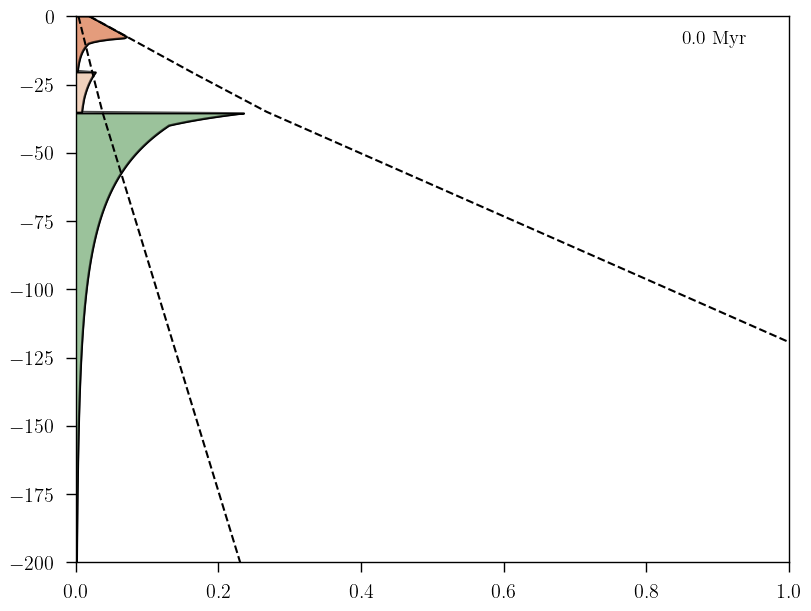

In [21]:


    

############################################################################################

#Extracting temperature dataset 

#selecting regions
i = 0
data = dataset.temperature[i].values.T #Nz vs Nx
time = dataset.time[i].values

############################################################################################
#Calculating mean temperature profile for different regions

xcenter = (Lx/2)/1.0e3
keel_mean_l = calc_mean_temperaure_region(data, Nz, xx, xcenter - 600, xcenter - 200)
keel_mean_c = calc_mean_temperaure_region(data, Nz, xx, xcenter - 100, xcenter + 100)
keel_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 200, xcenter + 600)

# # Tp_keel_l, fit_keel_l = Tp_estimate(keel_mean_l, z, 600, 300)
# # Tp_keel_c, fit_keel_c = Tp_estimate(keel_mean_c, z, 600, 300)
# # Tp_keel_r, fit_keel_r = Tp_estimate(keel_mean_r, z, 600, 300)

out_mean_l = calc_mean_temperaure_region(data, Nz, xx, 200, xcenter - 800)
out_mean_r = calc_mean_temperaure_region(data, Nz, xx, xcenter + 800, Lx/1.03 - 200)

# # Tp_out_l, fit_out_l = Tp_estimate(out_mean_l, z, 600, 200)
# # Tp_out_r, fit_out_r = Tp_estimate(out_mean_r, z, 600, 150)

############################################################################################
#Setting domain parameters for YSE calculation

# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3
# thickness of upper crust (m)
thickness_upper_crust = 20 * 1.0e3
# thickness of lower crust (m)
thickness_lower_crust = 15 * 1.0e3
# total thickness of lithosphere (m)
# thickness_litho = 80 * 1.0e3
thickness_litho = 200 * 1.0e3

# selecting below air layer
z_aux = z - thickness_sa/1.0e3
cond1 = z_aux >= 0

T_mean_region = keel_mean_l[cond1]
# T_mean_region = keel_mean_c[cond1]
# T_mean_region = keel_mean_r[cond1]
# T_mean_region = out_mean_l[cond1]
# T_mean_region = out_mean_r[cond1]

z_aux = z_aux[cond1]

f = interp1d(z_aux, T_mean_region)

###################################################################################
# Creating YSE

L = thickness_litho #80.0E3 #select from z axis of the scenario
N = int(2*thickness_litho/1.0e3 + 1) #len(L)
z_yse = np.linspace(0, L, N)
dz_yse = z_yse[1]-z_yse[0]

T_interp = f(z_yse/1.0e3)

rho = np.zeros_like(z_yse)
#conditions for regions
uc = z_yse<=20.0E3 #check from scenario
lc = (z_yse>20.0E3)&(z_yse<=35.0E3)
lm = (z_yse>35.0E3)

rho[uc]=2700.0
rho[lc]=2800.0
rho[lm]=3354.0
g = 10.0

P = 0.0
Paux = 0.0
for i in range(1,N):
    Paux += dz_yse*rho[i]*g
    P = np.append(P,Paux)

phi = 2.0*np.pi/180.0
c0 = 4.0E6
sigma_min = c0 * np.cos(phi) + P * np.sin(phi)

phi = 15.0*np.pi/180.0
c0 = 20.0E6
sigma_max = c0 * np.cos(phi) + P * np.sin(phi)

#rheological params
Q = np.zeros_like(z_yse)
A = np.zeros_like(z_yse)
n = np.zeros_like(z_yse)
V = np.zeros_like(z_yse)
C = np.zeros_like(z_yse)

Q[uc]=222000.0
Q[lc]=222000.0
Q[lm]=540000.0

A[uc]=8.574E-28
A[lc]=8.574E-28
A[lm]=2.4168E-15

n[uc]=4.0
n[lc]=4.0
n[lm]=3.5

V[uc]=0.0
V[lc]=0.0
V[lm]=25.0E-6

#strain rate (sr)
sr = 1.0E-15

#gas constant
R = 8.314

#print(n)

#Temperature Kelvin
TK = T_interp + 273

#Viscosity
#Choosing C for layers
C[uc]=1.0
Cslc = [10]
C[lm]=1.0

colors = ['black']
lines = ['-']

#########################################################################################################
#PLOT YSE

plt.close()            
fig, axs = plt.subplots(1, 1, figsize=(8,6), sharex=True, sharey=True, constrained_layout=True)

axs.text(0.85, 0.95, f"{time} Myr", fontsize=14, transform=axs.transAxes)

for clc, color, line in zip(Cslc, colors, lines):
    C[lc] = clc
    visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))

    sigma_v = visc * sr

    cond = sigma_v>sigma_max
    sigma_v[cond]=sigma_max[cond]
    axs.plot(sigma_v/1.0E9, -z_yse/1000, linestyle=line, color=color, alpha=0.7)

    if clc==Cslc[-1]:
        cr = 255.
        color_uc = (228./cr, 156./cr, 124./cr)
        color_lc = (240./cr, 209./cr, 188./cr)
        color_lit = (155./cr, 194./cr, 155./cr)
        color_ast = (207./cr, 226./cr, 205./cr)

        #filling inside YSE
        axs.fill_betweenx(-z_yse[uc]/1000,z_yse[uc]*0,sigma_v[uc]/1.0E9,color=color_uc,ec="k")
        axs.fill_betweenx(-z_yse[lc]/1000,z_yse[lc]*0,sigma_v[lc]/1.0E9,color=color_lc,ec="k")
        axs.fill_betweenx(-z_yse[lm]/1000,z_yse[lm]*0,sigma_v[lm]/1.0E9,color=color_lit,ec="k")

        gray=0.
        axs.plot(sigma_min/1.0E9,-z_yse/1000,"--",color=(gray,gray,gray))
        axs.plot(sigma_max/1.0E9,-z_yse/1000,"--",color=(gray,gray,gray))

axs.set_ylim([-thickness_litho/1.0e3, 0])
axs.set_xlim([0, 1.0])

In [148]:
dataset.time[-1].values

array(1000.)

# Process the information

In [ ]:
##############################################################################
# Plot b data: YSE
##############################################################################

L = 150.0E3 #select from z axis of the scenario
N = 151 #len(L)
z_yse = np.linspace(0,L,N)
dz_yse = z_yse[1]-z_yse[0]

rho = np.zeros_like(z_yse)
#conditions for regions
uc = z_yse<=20.0E3 #check from scenario
lc = (z_yse>15.0E3)&(z_yse<=40.0E3)
lm = (z_yse>35.0E3)

rho[uc]=2700.0
rho[lc]=2800.0
rho[lm]=3354.0
g = 10.0

P = 0.0
Paux = 0.0
for i in range(1,N):
    Paux += dz_yse*rho[i]*g
    P = np.append(P,Paux)

phi = 2.0*np.pi/180.0
c0 = 4.0E6
sigma_min = c0 * np.cos(phi) + P * np.sin(phi)

phi = 15.0*np.pi/180.0
c0 = 20.0E6
sigma_max = c0 * np.cos(phi) + P * np.sin(phi)

#rheological params
Q = np.zeros_like(z_yse)
A = np.zeros_like(z_yse)
n = np.zeros_like(z_yse)
V = np.zeros_like(z_yse)
C = np.zeros_like(z_yse)

Q[uc]=222000.0
Q[lc]=222000.0
Q[lm]=540000.0

A[uc]=8.574E-28
A[lc]=8.574E-28
A[lm]=2.4168E-15

n[uc]=4.0
n[lc]=4.0
n[lm]=3.5

V[uc]=0.0
V[lc]=0.0
V[lm]=25.0E-6

#interpolate the temperature field into the resolution
T_yse = 1300 * z_yse / L

kappa = 1.0e-6

ccapacity = 1250

H = np.zeros_like(z_yse)
Huc = 2.5E-6/2700.0#old 9.2e-10
Hlc = 0.8E-6/2800.0#old 2.9e-10

H[uc] = Huc
H[lc] = Hlc

Taux = np.copy(T_yse)
t = 0
dt = 1000
dt_sec = dt * 365 * 24 * 3600

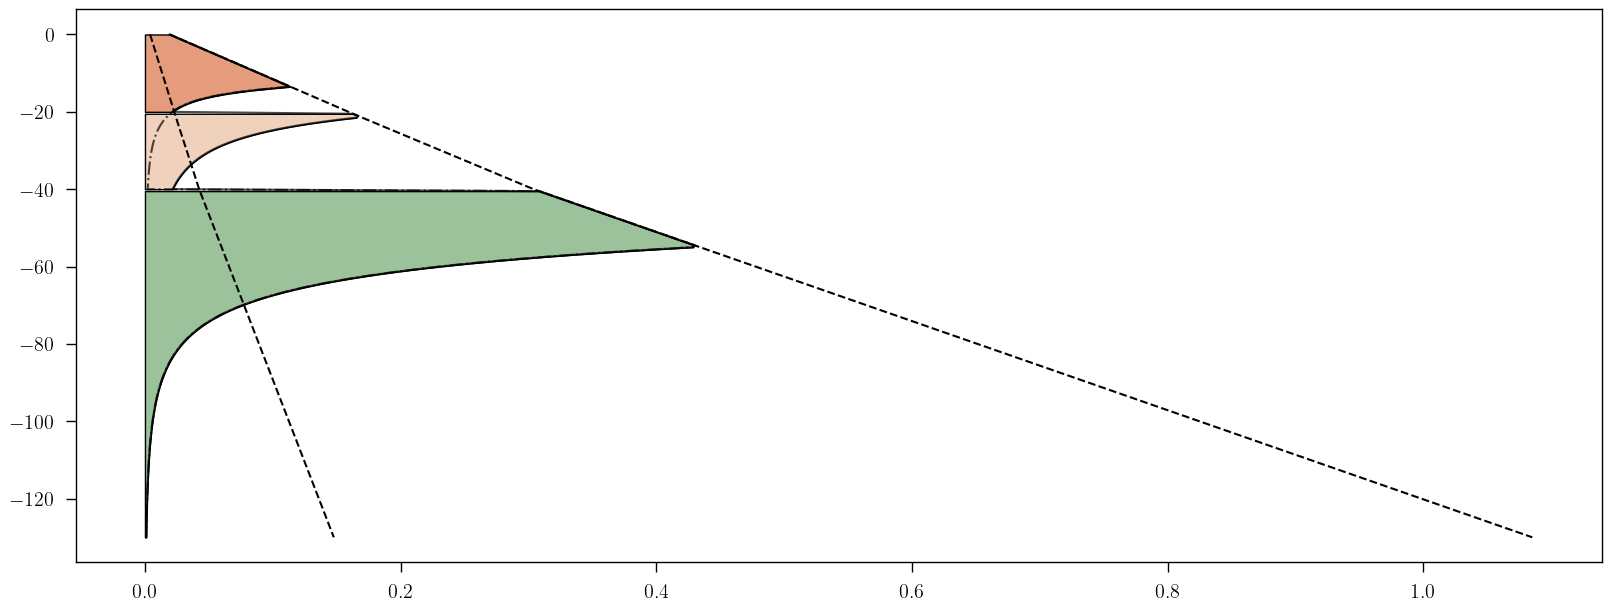

In [115]:
##############################################################################
# Plot b data: YSE
##############################################################################

L = 130.0E3 #select from z axis of the scenario
N = 261 #len(L)
z_yse = np.linspace(0,L,N)
dz_yse = z_yse[1]-z_yse[0]

rho = np.zeros_like(z_yse)
#conditions for regions
uc = z_yse<=20.0E3 #check from scenario
lc = (z_yse>20.0E3)&(z_yse<=40.0E3)
lm = (z_yse>40.0E3)

rho[uc]=2700.0
rho[lc]=2800.0
rho[lm]=3354.0
g = 10.0

P = 0.0
Paux = 0.0
for i in range(1,N):
    Paux += dz_yse*rho[i]*g
    P = np.append(P,Paux)

phi = 2.0*np.pi/180.0
c0 = 4.0E6
sigma_min = c0 * np.cos(phi) + P * np.sin(phi)

phi = 15.0*np.pi/180.0
c0 = 20.0E6
sigma_max = c0 * np.cos(phi) + P * np.sin(phi)

#rheological params
Q = np.zeros_like(z_yse)
A = np.zeros_like(z_yse)
n = np.zeros_like(z_yse)
V = np.zeros_like(z_yse)
C = np.zeros_like(z_yse)

Q[uc]=222000.0
Q[lc]=222000.0
Q[lm]=540000.0

A[uc]=8.574E-28
A[lc]=8.574E-28
A[lm]=2.4168E-15

n[uc]=4.0
n[lc]=4.0
n[lm]=3.5

V[uc]=0.0
V[lc]=0.0
V[lm]=25.0E-6

T_yse = 1300 * z_yse / L

kappa = 1.0e-6

ccapacity = 1250

H = np.zeros_like(z_yse)
Huc = 2.5E-6/2700.0#old 9.2e-10
Hlc = 0.8E-6/2800.0#old 2.9e-10

H[uc] = Huc
H[lc] = Hlc

Taux = np.copy(T_yse)
t = 0
dt = 1000
dt_sec = dt * 365 * 24 * 3600


#take the temperature field from scenario
while t < 500.0e6:
    T_yse[1:-1] += kappa*dt_sec*((T_yse[2:]+T_yse[:-2]-2*T_yse[1:-1])/dz_yse**2) + H[1:-1]*dt_sec/ccapacity
    t = t + dt

#plt.plot(T,-z/1000)

#strain rate (sr)
sr = 1.0E-15

#gas constant
R = 8.314

#print(n)

#Temperature Kelvin
TK = T_yse + 273 #from scenario will be in K

#Viscosity
#Choosing C for layers
C[uc]=1.0
Cslc = [1, 10]
C[lm]=1.0


plt.close()            
fig, axs = plt.subplots(1, 1, figsize=(16,6), sharex=True, sharey=True, constrained_layout=True)

colors = ['black','black']
lines = ['-.', '-']

for clc, color, line in zip(Cslc, colors, lines):
    C[lc] = clc
    visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))

    sigma_v = visc * sr

    cond = sigma_v>sigma_max
    sigma_v[cond]=sigma_max[cond]
    axs.plot(sigma_v/1.0E9, -z_yse/1000, linestyle=line, color=color, alpha=0.7)

    if clc==Cslc[-1]:
        cr = 255.
        color_uc = (228./cr, 156./cr, 124./cr)
        color_lc = (240./cr, 209./cr, 188./cr)
        color_lit = (155./cr, 194./cr, 155./cr)
        color_ast = (207./cr, 226./cr, 205./cr)

        #filling inside YSE
        axs.fill_betweenx(-z_yse[uc]/1000,z_yse[uc]*0,sigma_v[uc]/1.0E9,color=color_uc,ec="k")
        axs.fill_betweenx(-z_yse[lc]/1000,z_yse[lc]*0,sigma_v[lc]/1.0E9,color=color_lc,ec="k")
        axs.fill_betweenx(-z_yse[lm]/1000,z_yse[lm]*0,sigma_v[lm]/1.0E9,color=color_lit,ec="k")

        gray=0.
        axs.plot(sigma_min/1.0E9,-z_yse/1000,"--",color=(gray,gray,gray))
        axs.plot(sigma_max/1.0E9,-z_yse/1000,"--",color=(gray,gray,gray))


# plt.close()            
# fig, axs = plt.subplots(1, 5, figsize=(16,6), sharex=True, sharey=True, constrained_layout=True)